In [1]:
import torch
import torch.nn as nn
from thop import profile
import os
from pathlib import Path
import pandas as pd
##---------- Basic Layers ----------
def conv3x3(in_chn, out_chn, bias=True):
    layer = nn.Conv2d(in_chn, out_chn, kernel_size=3, stride=1, padding=1, bias=bias)
    return layer


def conv(in_channels, out_channels, kernel_size, bias=False, stride=1):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size,
        padding=(kernel_size // 2),
        bias=bias,
        stride=stride,
    )


def bili_resize(factor):
    return nn.Upsample(scale_factor=factor, mode="bilinear", align_corners=False)


##---------- Basic Blocks ----------
class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, downsample):
        super(UNetConvBlock, self).__init__()
        self.downsample = downsample
        self.block = SK_RDB(in_channels=in_size, growth_rate=out_size, num_layers=3)
        if downsample:
            self.downsample = PS_down(out_size, out_size, downscale=2)

    def forward(self, x):
        out = self.block(x)
        if self.downsample:
            out_down = self.downsample(out)
            return out_down, out
        else:
            return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size):
        super(UNetUpBlock, self).__init__()
        # self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2, bias=True)
        self.up = PS_up(in_size, out_size, upscale=2)
        self.conv_block = UNetConvBlock(in_size, out_size, False)

    def forward(self, x, bridge):
        up = self.up(x)
        out = torch.cat([up, bridge], dim=1)
        out = self.conv_block(out)
        return out


##---------- Resizing Modules (Pixel(Un)Shuffle) ----------
class PS_down(nn.Module):
    def __init__(self, in_size, out_size, downscale):
        super(PS_down, self).__init__()
        self.UnPS = nn.PixelUnshuffle(downscale)
        self.conv1 = nn.Conv2d((downscale**2) * in_size, out_size, 1, 1, 0)

    def forward(self, x):
        x = self.UnPS(x)  # h/2, w/2, 4*c
        x = self.conv1(x)
        return x


class PS_up(nn.Module):
    def __init__(self, in_size, out_size, upscale):
        super(PS_up, self).__init__()

        self.PS = nn.PixelShuffle(upscale)
        self.conv1 = nn.Conv2d(in_size // (upscale**2), out_size, 1, 1, 0)

    def forward(self, x):
        x = self.PS(x)  # h/2, w/2, 4*c
        x = self.conv1(x)
        return x


##---------- Selective Kernel Feature Fusion (SKFF) ----------
class SKFF(nn.Module):
    def __init__(self, in_channels, height=3, reduction=8, bias=False):
        super(SKFF, self).__init__()

        self.height = height
        d = max(int(in_channels / reduction), 4)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv_du = nn.Sequential(
            nn.Conv2d(in_channels, d, 1, padding=0, bias=bias), nn.PReLU()
        )

        self.fcs = nn.ModuleList([])
        for i in range(self.height):
            self.fcs.append(
                nn.Conv2d(d, in_channels, kernel_size=1, stride=1, bias=bias)
            )

        self.softmax = nn.Softmax(dim=1)

    def forward(self, inp_feats):
        batch_size, n_feats, H, W = inp_feats[1].shape

        inp_feats = torch.cat(inp_feats, dim=1)
        inp_feats = inp_feats.view(
            batch_size, self.height, n_feats, inp_feats.shape[2], inp_feats.shape[3]
        )

        feats_U = torch.sum(inp_feats, dim=1)
        feats_S = self.avg_pool(feats_U)
        feats_Z = self.conv_du(feats_S)

        attention_vectors = [fc(feats_Z) for fc in self.fcs]
        attention_vectors = torch.cat(attention_vectors, dim=1)
        attention_vectors = attention_vectors.view(
            batch_size, self.height, n_feats, 1, 1
        )

        attention_vectors = self.softmax(attention_vectors)
        feats_V = torch.sum(inp_feats * attention_vectors, dim=1)

        return feats_V


##---------- Dense Block ----------
class DenseLayer(nn.Module):
    def __init__(self, in_channels, out_channels, I):
        super(DenseLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=3 // 2)
        self.relu = nn.ReLU(inplace=True)
        self.sk = SKFF(out_channels, height=2, reduction=8, bias=False)

    def forward(self, x):
        x1 = self.relu(self.conv(x))
        # output = torch.cat([x, x1], 1) # -> RDB
        output = self.sk((x, x1))
        return output


##---------- Selective Kernel Residual Dense Block (SK-RDB) ----------
class SK_RDB(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(SK_RDB, self).__init__()
        self.identity = nn.Conv2d(in_channels, growth_rate, 1, 1, 0)
        self.layers = nn.Sequential(
            *[DenseLayer(in_channels, in_channels, I=i) for i in range(num_layers)]
        )
        self.lff = nn.Conv2d(in_channels, growth_rate, kernel_size=1)

    def forward(self, x):
        res = self.identity(x)
        x = self.layers(x)
        x = self.lff(x)
        return res + x


##---------- testNet ----------
class SRMNet(nn.Module):
    def __init__(self, in_chn=3, wf=96, depth=4):
        super(SRMNet, self).__init__()
        self.depth = depth
        self.down_path = nn.ModuleList()
        self.bili_down = bili_resize(0.5)
        self.conv_01 = nn.Conv2d(in_chn, wf, 3, 1, 1)

        # encoder of UNet
        prev_channels = 0
        for i in range(depth):  # 0,1,2,3
            downsample = True if (i + 1) < depth else False
            self.down_path.append(
                UNetConvBlock(prev_channels + wf, (2**i) * wf, downsample)
            )
            prev_channels = (2**i) * wf

        # decoder of UNet
        self.up_path = nn.ModuleList()
        self.skip_conv = nn.ModuleList()
        self.conv_up = nn.ModuleList()
        self.bottom_conv = nn.Conv2d(prev_channels, wf, 3, 1, 1)
        self.bottom_up = bili_resize(2 ** (depth - 1))

        for i in reversed(range(depth - 1)):
            self.up_path.append(UNetUpBlock(prev_channels, (2**i) * wf))
            self.skip_conv.append(nn.Conv2d((2**i) * wf, (2**i) * wf, 3, 1, 1))
            self.conv_up.append(
                nn.Sequential(
                    *[nn.Conv2d((2**i) * wf, wf, 3, 1, 1), bili_resize(2**i)]
                )
            )
            prev_channels = (2**i) * wf

        self.final_ff = SKFF(in_channels=wf, height=depth)
        self.last = conv3x3(prev_channels, in_chn, bias=True)

    def forward(self, x):
        img = x
        scale_img = img

        ##### shallow conv #####
        x1 = self.conv_01(img)
        encs = []
        ######## UNet ########
        # Down-path (Encoder)
        for i, down in enumerate(self.down_path):
            if i == 0:
                x1, x1_up = down(x1)
                encs.append(x1_up)
            elif (i + 1) < self.depth:
                scale_img = self.bili_down(scale_img)
                left_bar = self.conv_01(scale_img)
                x1 = torch.cat([x1, left_bar], dim=1)
                x1, x1_up = down(x1)
                encs.append(x1_up)
            else:
                scale_img = self.bili_down(scale_img)
                left_bar = self.conv_01(scale_img)
                x1 = torch.cat([x1, left_bar], dim=1)
                x1 = down(x1)

        # Up-path (Decoder)
        ms_result = [self.bottom_up(self.bottom_conv(x1))]
        for i, up in enumerate(self.up_path):
            x1 = up(x1, self.skip_conv[i](encs[-i - 1]))
            ms_result.append(self.conv_up[i](x1))
        # Multi-scale selective feature fusion
        msff_result = self.final_ff(ms_result)

        ##### Reconstruct #####
        out_1 = self.last(msff_result) + img

        return out_1

In [2]:
from datasets import load_dataset
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from einops import repeat
from transformers.optimization import (
    get_linear_schedule_with_warmup,
    get_cosine_schedule_with_warmup,
)
from fastprogress.fastprogress import master_bar, progress_bar
from fastai.vision.all import L, unsqueeze
from timm.data.mixup import Mixup
from timm.loss import (
    LabelSmoothingCrossEntropy,
    BinaryCrossEntropy,
    SoftTargetCrossEntropy,
)

from einops import rearrange

# load dataset from the hub
dataset = load_dataset("fashion_mnist")
image_size = 128
channels = 1
batch_size = 128

Found cached dataset fashion_mnist (/root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [4]:
transform = Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

In [5]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start


def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [6]:
timesteps = 200

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

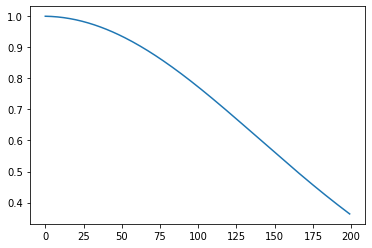

In [7]:
plt.plot(sqrt_alphas_cumprod)

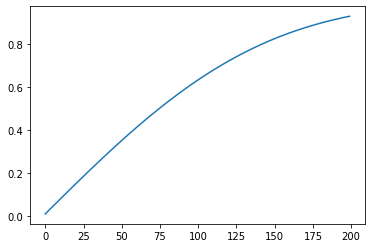

In [8]:
plt.plot(sqrt_one_minus_alphas_cumprod)

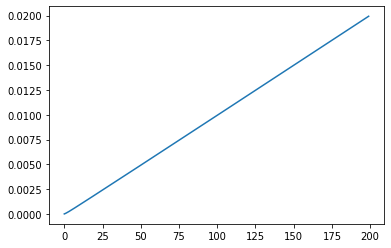

In [9]:
plt.plot(posterior_variance)

In [10]:
# forward diffusion (using the nice property)
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise


def get_noisy_image(x_start, t):
    # add noise
    x_noisy = q_sample(x_start, t=t)



    return x_noisy

reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(), # turn into Numpy array of shape HWC, divide by 255
    Lambda(lambda t: (t * 2) - 1),
    
])

class SaveModel:
    def __init__(self, folder, exp_name, best=np.inf):
        self.best = best
        self.folder = Path(folder) / f"{exp_name}.pth"

    def __call__(self, score, model, epoch):
        if score < self.best:
            self.best = score
            print(f"Better model found at epoch {epoch} with value: {self.best}.")
            torch.save(model.state_dict(), self.folder)


class SaveModelMetric:
    def __init__(self, folder, exp_name, best=-np.inf):
        self.best = best
        self.folder = Path(folder) / f"{exp_name}.pth"

    def __call__(self, score, model, epoch):
        if score > self.best:
            self.best = score
            print(f"Better model found at epoch {epoch} with value: {self.best}.")
            torch.save(model.state_dict(), self.folder)


class SaveModelEpoch:
    def __init__(self, folder, exp_name, best=-np.inf):
        self.best = best
        self.folder = Path(folder)
        self.exp_name = exp_name

    def __call__(self, score, model, epoch):
        self.best = score
        print(f"Better model found at epoch {epoch} with value: {self.best}.")
        torch.save(model.state_dict(), f"{self.folder/self.exp_name}_{epoch}.pth")


def custom_auc_score(p, gt):
    return roc_auc_score(gt.cpu().numpy(), F.softmax(p).cpu().numpy()[:, 1])


def fit_mixup(
    epochs,
    model,
    train_dl,
    valid_dl,
    loss_fn,
    opt,
    metric,
    folder="models",
    exp_name="exp_00",
    device=None,
    sched=None,
    save_md=SaveModelEpoch,
):
    if device is None:
        device = (
            torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        )

    os.makedirs(folder, exist_ok=True)
    loss_fn_trn = loss_fn
    mb = master_bar(range(epochs))
    mb.write(["epoch", 
              "train_loss",
              "valid_loss",
              "val_metric"], table=True)
    model.to(device)  # we have to put our model on gpu
    scaler = torch.cuda.amp.GradScaler()  # this for half precision training
    save_md = save_md(folder, exp_name)

    for i in mb:  # iterating  epoch
        trn_loss, val_loss = 0.0, 0.0
        trn_n, val_n = len(train_dl.dataset), len(valid_dl.dataset)
        model.train()  # set model for training
        for (xb, yb) in progress_bar(train_dl, parent=mb):
            xb, yb = xb.to(device), yb.to(device)  # putting batches to device
            with torch.cuda.amp.autocast():  # half precision
                out = model(xb)  # forward pass
                loss = loss_fn_trn(out, yb)  # calulation loss
            trn_loss += loss.item()

            scaler.scale(loss).backward()  # backward
            scaler.step(opt)  # optimzers step
            scaler.update()  # for half precision
            opt.zero_grad()  # zeroing optimizer
            if sched is not None:
                sched.step()  # scuedular step

        trn_loss /= mb.child.total

        # putting model in eval mode
        model.eval()
        gt = []
        pred = []
        # after epooch is done we can run a validation dataloder and see how are doing
        with torch.no_grad():
            for (xb, yb) in progress_bar(valid_dl, parent=mb):
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = loss_fn(out, yb)
                val_loss += loss.item()

                gt.append(yb.detach())
                pred.append(out.detach())
        # calculating metric
        metric_ = metric(torch.cat(pred), torch.cat(gt))
        # saving model if necessary
        save_md(metric_, model, i)
        val_loss /= mb.child.total

        pd.DataFrame(
            {
                "trn_loss": [trn_loss],
                "val_loss": [val_loss],
                "metric": [metric_.detach().cpu().numpy()],
            }
        ).to_csv(f"{folder}/{exp_name}_{i}.csv", index=False)
        mb.write(
            [
                i,
                f"{trn_loss:.6f}",
                f"{val_loss:.6f}",
                f"{metric_:.6f}",
            ],
            table=True,
        )
    print("Training done")
    # loading the best checkpoint

In [11]:
#train = dataset['train']
#image = train[0]['image']
#x_start = transform(image).unsqueeze(0)
#noise_level = torch.randint(1, 80, (1,))
#x_noisy = get_noisy_image(x_start, noise_level)
#noise_level

In [83]:
class CharbonnierLoss(nn.Module):
    """Charbonnier Loss (L1)"""

    def __init__(self, eps=1e-3):
        super(CharbonnierLoss, self).__init__()
        self.eps = eps

    def forward(self, x, y):
        diff = x - y
        # loss = torch.sum(torch.sqrt(diff * diff + self.eps))
        loss = torch.mean(torch.sqrt((diff * diff) + (self.eps*self.eps)))
        return loss

class FashionTrainDataset:
    def __init__(self, ds):
        self.ds = ds

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        image = self.ds[idx]["image"]
        x_start = transform(image).unsqueeze(0)
        noise_level = torch.randint(1, 100, (1,))
        x_noisy = get_noisy_image(x_start, noise_level)
        return repeat(
            x_noisy[0][0], "h w -> c h w", c=3
        ), repeat(x_start[0][0], "h w -> c h w", c=3)


def customplot(x, y, k=None):
    if k:
        plt.imshow(torch.concat([x.mean(0), y.mean(0), k.mean(0)], 1))
    else:
        plt.imshow(torch.concat([x.mean(0), y.mean(0)], 1))

In [38]:
class CFG:
    bs = 96
    nw = 4
    model_name = "SRG"
    lr = 1e-3
    wd = 1e-4
    epoch = 5
    warmup_pct = 0.1
    num_classes = 2
    dropout_rate = 0.3
    folder = "EXP_40_01"
    exp_name = f"{folder}_{model_name}"

In [39]:
trn_ds = FashionTrainDataset(dataset['train'])
vld_ds = FashionTrainDataset(dataset['test'])


In [40]:
len(trn_ds)

60000

In [16]:
trn_dl = DataLoader(
    trn_ds,
    batch_size=CFG.bs,
    shuffle=True,
    num_workers=CFG.nw,
    pin_memory=True,
    drop_last=True,
)
vld_dl = DataLoader(
    vld_ds,
    batch_size=CFG.bs,
    shuffle=False,
    num_workers=CFG.nw,
    pin_memory=True,
)
custom_model = SRMNet()
opt = torch.optim.AdamW(custom_model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
loss_func = CharbonnierLoss()
warmup_steps = int(len(trn_dl) * int(CFG.warmup_pct * CFG.epoch))
total_steps = int(len(trn_dl) * CFG.epoch)
sched = get_linear_schedule_with_warmup(
    opt, num_warmup_steps=warmup_steps, num_training_steps=total_steps
)

fit_mixup(
    epochs=CFG.epoch,
    model=custom_model,
    train_dl=trn_dl,
    valid_dl=vld_dl,
    loss_fn=loss_func,
    opt=opt,
    metric=CharbonnierLoss(),
    folder=CFG.folder,
    exp_name=f"{CFG.exp_name}",
    device="cuda:1",
    sched=sched,
)

epoch,train_loss,valid_loss,val_metric
0,0.060145,0.033476,0.033464
1,0.028923,0.027005,0.026934
2,0.025763,0.024593,0.024621
3,0.023400,0.022528,0.022484
4,0.022014,0.021889,0.021871


Better model found at epoch 0 with value: 0.03346365690231323.
Better model found at epoch 1 with value: 0.02693360485136509.
Better model found at epoch 2 with value: 0.02462090738117695.
Better model found at epoch 3 with value: 0.022483984008431435.
Better model found at epoch 4 with value: 0.02187061309814453.
Training done


In [69]:
custom_model = SRMNet()
custom_model.load_state_dict(torch.load('EXP_40_01/EXP_40_01_SRG_4.pth'))
custom_model.cuda();
custom_model.eval();

In [144]:
class FashionTrainDatasetValid:
    def __init__(self, ds):
        self.ds = ds

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        image = self.ds[idx]["image"]
        x_start = transform(image).unsqueeze(0)
        out = []
        for i in [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 140, 199]:
            noise_level = torch.tensor([i])
            x_noisy = get_noisy_image(x_start, noise_level)
            out.append(repeat(
            x_noisy[0][0], "h w -> c h w", c=3
        ))
        return out

In [145]:
vld_ds = FashionTrainDatasetValid(dataset['test'])
img = vld_ds[440]
img_pred = torch.stack(img)
with torch.no_grad():
    out = custom_model(img_pred.cuda()).detach().cpu()

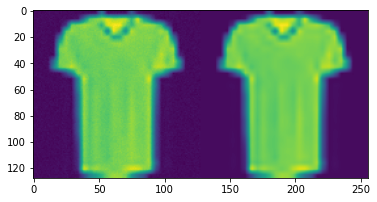

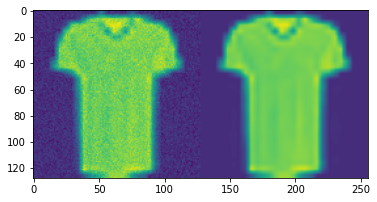

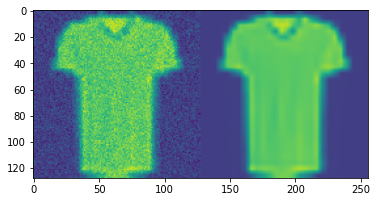

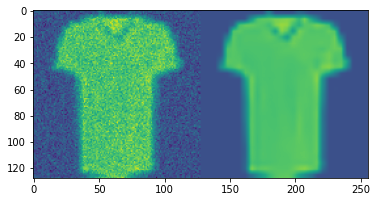

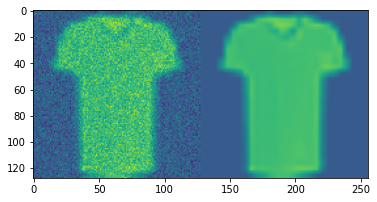

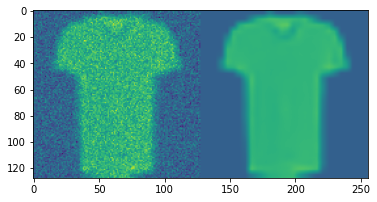

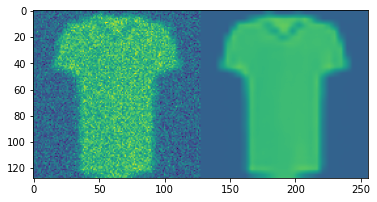

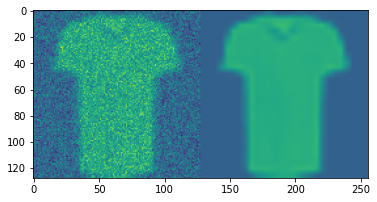

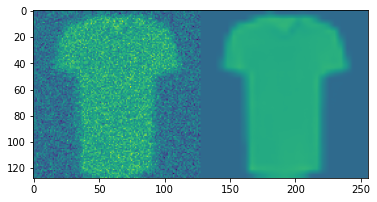

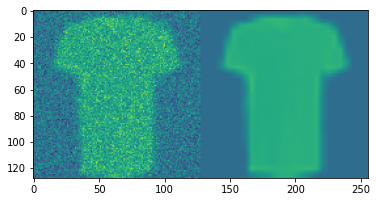

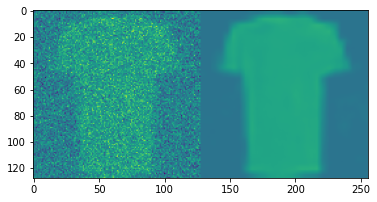

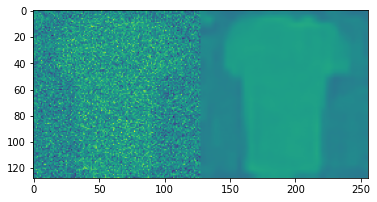

In [146]:
for i, k  in zip(img, out):
    customplot(i, k)
    plt.pause(0.1)

In [148]:
out[-1].s

tensor([[[ 0.0140, -0.2611, -0.2708,  ..., -0.9428, -0.9871, -0.8630],
         [-0.3083, -0.2496, -0.2454,  ..., -0.9713, -0.9585, -0.9416],
         [-0.1971, -0.2102, -0.2514,  ..., -0.9633, -0.9593, -0.9818],
         ...,
         [-0.6928, -0.6554, -0.6633,  ..., -0.9155, -0.8942, -0.8895],
         [-0.7973, -0.6430, -0.6754,  ..., -0.8946, -0.8951, -0.8598],
         [-0.0611, -0.6791, -0.6707,  ..., -0.9166, -0.8615, -0.7649]],

        [[ 0.0191, -0.2476, -0.2525,  ..., -0.9477, -0.9728, -0.8534],
         [-0.2925, -0.2346, -0.2318,  ..., -0.9748, -0.9559, -0.9496],
         [-0.1922, -0.2073, -0.2529,  ..., -0.9653, -0.9623, -0.9873],
         ...,
         [-0.6964, -0.6436, -0.6577,  ..., -0.9200, -0.9067, -0.8859],
         [-0.8113, -0.6301, -0.6781,  ..., -0.8908, -0.8949, -0.8580],
         [-0.0847, -0.6992, -0.6765,  ..., -0.9209, -0.8729, -0.8089]],

        [[ 0.0292, -0.2514, -0.2683,  ..., -0.9412, -0.9834, -0.8526],
         [-0.2878, -0.2496, -0.2399,  ..., -0